### Introducción

En esta práctica, automatizamos el proceso de convertir imágenes de menús en una hoja de cálculo de Excel estructurada utilizando el modelo GPT de OpenAI. El script lee imágenes de un directorio específico, procesa cada imagen para extraer los datos de la carta de un restaurante y compila la información extraída en un archivo de Excel siguiendo una plantilla predefinida.

### Setup

In [1]:
from dotenv import load_dotenv
import os

load_dotenv(override=True)
api_key = os.getenv('GOOGLE_API_KEY')

A continuación, importamos todas las librerías necesarias para el procesamiento de imágenes, la gestión de datos y la interacción con la API de OpenAI.

In [2]:
# Load the libraries
from openai import OpenAI
import os
import base64
from IPython.display import Image, display, Markdown
import pandas as pd

Usamos un modelo de Google Gemini capaz de procesar imágenes y extraer texto de ellas.

In [3]:
# Set up the OpenAI client and specify the model to use
MODEL = "gemini-2.5-flash-preview-05-20"
client = OpenAI(
    api_key=api_key, # Use the provided API key for authentication
    base_url="https://generativelanguage.googleapis.com/v1beta" 
)

### Definiendo el mensaje del sistema

In [8]:
system_prompt = """
Convierte la imagen del menú en un formato estructurado de hoja de Excel siguiendo la plantilla e instrucciones proporcionadas.
Este asistente convierte datos de menús de restaurantes o cafeterías en una hoja de Excel estructurada que se ajusta a una plantilla específica.
La plantilla incluye categorías, subcategorías, nombres de los artículos, precios, descripciones y más, garantizando la consistencia de los datos.
Este asistente ayuda a los usuarios a completar correctamente cada fila, siguiendo las instrucciones detalladas proporcionadas.

Resumen:
- Cada fila en la hoja de cálculo de Excel representa un artículo único, categorizado bajo una categoría o subcategoría.
- Los nombres de categorías y subcategorías se repiten para los artículos dentro de la misma subcategoría.
- Ciertas columnas deben dejarse en blanco cuando no correspondan, como los detalles de subcategoría para artículos directamente bajo una categoría.
- Los detalles de cada artículo, incluidos nombres, precios y descripciones, deben ser únicos para cada entrada.
- El contenido del menú cargado se añadirá al menú existente sin eliminar ninguna entrada actual.
- Las columnas que terminan en "Es" son para traducciones al español, "Pt" para portugués y "En" para inglés.
- Deberás traducir al español los valores que estén en portugués.

IMPORTANTE: La salida debe ser ÚNICAMENTE una tabla de Markdown 
con EXACTAMENTE las siguientes columnas (ni más ni menos):

Nombre de columna                  | Descripción                                   | Valores aceptados                | Ejemplo
-----------------------------------|-----------------------------------------------|----------------------------------|-----------------------
CategoryTitleEs (Columna A)        | Traducciones al español de los nombres de categoría              | Texto, máximo 256 caracteres     | Bebidas
CategoryTitlePt (Columna B)        | Nombres de categorías en portugués            | Texto, máximo 256 caracteres     | Bebidas
CategoryTitleEn (Columna C) (Opcional) | Traducciones al inglés de los nombres de categoría | Texto, máximo 256 caracteres | Beverages
SubcategoryTitleEs (Columna D) (Opcional) | Traducciones al español de los nombres de subcategoría   | Texto, máximo 256 caracteres o en blanco | Zumos
SubcategoryTitlePt (Columna E) (Opcional) | Nombres de subcategorías en portugués   | Texto, máximo 256 caracteres o en blanco | Sucos
SubcategoryTitleEn (Columna F) (Opcional) | Traducciones al inglés de los nombres de subcategoría | Texto, máximo 256 caracteres o en blanco | Juices
ItemNameEs (Columna G)             | Traducciones al español de los nombres de los artículos         | Texto, máximo 256 caracteres     | Agua Mineral
ItemNamePt (Columna H)             | Nombres de los artículos en portugués         | Texto, máximo 256 caracteres     | Água Mineral
ItemNameEn (Columna I) (Opcional)  | Traducciones al inglés de los nombres de los artículos | Texto, máximo 256 caracteres o en blanco | Mineral Water
ItemPrice (Columna J)              | Precio de cada artículo sin símbolo de moneda | Texto                           | 2.50 o 2,50
Calories (Columna K) (Opcional)    | Contenido calórico de cada artículo           | Numérico                        | 150
PortionSize (Columna L)            | Tamaño de la porción de cada artículo en unidades | Texto                      | 500ml, 1, 2-3
Availability (Columna M) (Opcional)| Disponibilidad actual del artículo            | Numérico: 1 para Sí, 0 para No  | 1
ItemDescriptionEs (Columna N) (Opcional) | Descripción detallada en español      | Texto, máximo 500 caracteres     | Contiene minerales esenciales
ItemDescriptionPt (Columna O) (Opcional) | Descripción detallada en portugués      | Texto, máximo 500 caracteres     | Contém minerais essenciais
ItemDescriptionEn (Columna P) (Opcional) | Descripción detallada en inglés        | Texto, máximo 500 caracteres     | Contains essential minerals

Notas:
- Asegúrate de que todos los datos ingresados sigan los formatos especificados para mantener la integridad de la base de datos.
- Revisa los datos para garantizar su precisión y consistencia antes de enviar la hoja de Excel.
"""

Este `prompt` proporciona al modelo instrucciones completas sobre cómo procesar las imágenes del menú y el formato exacto esperado para la salida en Excel. Incluye una descripción general, descripciones de las columnas y ejemplos para garantizar la coherencia y precisión en el proceso de extracción de datos.

Creamos una función que convierte una imagen a Base64

In [5]:
# IMAGE_DIR = "imgs/menus/Regatta"
IMAGE_DIR = "../imgs/menus/Dim Sum"

def encode_image(image_path):
    # Open the image file in binary mode and encode it in Base64
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Process imaged in the directory
image_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
image_files

['DimSum Amoreiras 1.PNG',
 'DimSum Amoreiras 2.PNG',
 'DimSum Amoreiras 3.PNG',
 'DimSum Amoreiras 4.PNG',
 'DimSum Amoreiras 5.PNG']

Codificar imágenes en Base64 nos permite incluir los datos de la imagen directamente en nuestras solicitudes a la API sin depender de URLs externas.

Este código escanea el directorio en busca de archivos que terminen en `.png`, `.jpg` o `.jpeg`, asegurando que solo procesamos los archivos de imagen relevantes para nuestra tarea.

Mostramos una imagen de ejemplo.

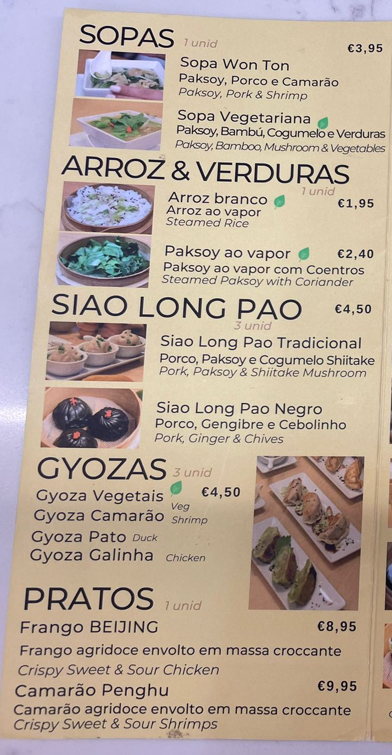

In [6]:
display(Image(filename=os.path.join(IMAGE_DIR, image_files[0]), width=300))

Probamos a enviar una imagen y comprobamos que se genera una tabla de Markdown con los datos del menú.

In [9]:
image_path = os.path.join(IMAGE_DIR, image_files[0])  # Use the first image in the directory
image_data = encode_image(image_path)

response = client.chat.completions.create(
    model=MODEL,
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": [
            {'type': 'text',
             'text': "Convierte esta imagen de menú en un formato estructurado de hoja de Excel."},
            {'type': 'image_url',
             'image_url': {'url': f'data:image/png;base64,{image_data}'}}
        ]}
    ],
    temperature=0
)

response.choices[0].message.content

'```markdown\n| CategoryTitleEs | CategoryTitlePt | CategoryTitleEn | SubcategoryTitleEs | SubcategoryTitlePt | SubcategoryTitleEn | ItemNameEs | ItemNamePt | ItemNameEn | ItemPrice | Calories | PortionSize | Availability | ItemDescriptionEs | ItemDescriptionPt | ItemDescriptionEn |\n|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|\n| Sopas | Sopas | Soups | | | | Sopa Won Ton | Sopa Won Ton | Won Ton Soup | 3,95 | | 1 unid | 1 | Paksoy, Cerdo y Camarón | Paksoy, Porco e Camarão | Paksoy, Pork & Shrimp |\n| Sopas | Sopas | Soups | | | | Sopa Vegetariana | Sopa Vegetariana | Vegetarian Soup | | | 1 unid | 1 | Paksoy, Bambú, Champiñón y Verduras | Paksoy, Bambú, Cogumelo e Verduras | Paksoy, Bamboo, Mushroom & Vegetables |\n| Arroz y Verduras | Arroz & Verduras | Rice & Vegetables | | | | Arroz blanco | Arroz branco | Steamed Rice | 1,95 | | 1 unid | 1 | Arroz al vapor | Arroz ao vapor | Steamed Rice |\n| Arroz y Verduras | Arroz & Verduras | Rice & Vegetables | | | | Pa

Convertimos la respuesta del modelo a un DataFrame de Pandas para facilitar su manipulación y exportación a Excel.

In [10]:
df = pd.DataFrame(columns=['CategoryTitleEs', 'CategoryTitlePt', 'CategoryTitleEn', 'SubcategoryTitleEs', 'SubcategoryTitlePt', 'SubcategoryTitleEn',
                           'ItemNameEs', 'ItemNamePt', 'ItemNameEn', 'ItemPrice', 'Calories', 'PortionSize', 'Availability',
                           'ItemDescriptionEs', 'ItemDescriptionPt', 'ItemDescriptionEn'])

print(f"Procesando la respuesta del modelo para {image_path}")
for row in response.choices[0].message.content.split('\n'):
    if row.startswith('|') and not row.startswith('|-'): # Ensure that the data is a row and not a header format
      columns = [col.strip() for col in row.split('|')[1:-1]]
      if len(columns) == len(df.columns):
        if 'CategoryTitleEs' in columns:
          headers_added = True
          continue
        if headers_added and 'CategoryTitleEs' in columns:
          continue # skip the row
        new_row = pd.Series(columns, index=df.columns)
        print(f"\tAñadiendo nuevo plato: {new_row['CategoryTitlePt']}/{new_row['ItemNamePt']}")
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
      else:
        print(f"Saltándose fila { row}")
df

Procesando la respuesta del modelo para ../imgs/menus/Dim Sum/DimSum Amoreiras 1.PNG
	Añadiendo nuevo plato: Sopas/Sopa Won Ton
	Añadiendo nuevo plato: Sopas/Sopa Vegetariana
	Añadiendo nuevo plato: Arroz & Verduras/Arroz branco
	Añadiendo nuevo plato: Arroz & Verduras/Paksoy ao vapor
	Añadiendo nuevo plato: Siao Long Pao/Siao Long Pao Tradicional
	Añadiendo nuevo plato: Siao Long Pao/Siao Long Pao Negro
	Añadiendo nuevo plato: Gyozas/Gyoza Vegetais
	Añadiendo nuevo plato: Gyozas/Gyoza Camarão
	Añadiendo nuevo plato: Gyozas/Gyoza Pato
	Añadiendo nuevo plato: Gyozas/Gyoza Galinha
	Añadiendo nuevo plato: Pratos/Frango BEIJING
	Añadiendo nuevo plato: Pratos/Camarão Penghu


CategoryTitleEs   CategoryTitlePt    CategoryTitleEn SubcategoryTitleEs  \
0              Sopas             Sopas              Soups                      
1              Sopas             Sopas              Soups                      
2   Arroz y Verduras  Arroz & Verduras  Rice & Vegetables                      
3   Arroz y Verduras  Arroz & Verduras  Rice & Vegetables                      
4      Siao Long Pao     Siao Long Pao      Siao Long Pao                      
5      Siao Long Pao     Siao Long Pao      Siao Long Pao                      
6             Gyozas            Gyozas             Gyozas                      
7             Gyozas            Gyozas             Gyozas                      
8             Gyozas            Gyozas             Gyozas                      
9             Gyozas            Gyozas             Gyozas                      
10            Platos            Pratos             Dishes                      
11            Platos            Pratos             Dishes                      

   SubcategoryTitlePt SubcategoryTitleEn                 ItemNameEs  \
0                                                      Sopa Won Ton   
1                                                  Sopa Vegetariana   
2                                                      Arroz blanco   
3                                                   Paksoy al vapor   
4                                         Siao Long Pao Tradicional   
5                                               Siao Long Pao Negro   
6                                                   Gyoza Vegetales   
7                                                     Gyoza Camarón   
8                                                        Gyoza Pato   
9                                                       Gyoza Pollo   
10                                                    Pollo BEIJING   
11                                                   Camarón Penghu   

                   ItemNamePt                 ItemNameEn ItemPrice Calories  \
0                Sopa Won Ton               Won Ton Soup      3,95            
1            Sopa Vegetariana            Vegetarian Soup                      
2                Arroz branco               Steamed Rice      1,95            
3             Paksoy ao vapor             Steamed Paksoy      2,40            
4   Siao Long Pao Tradicional  Traditional Siao Long Pao      4,50            
5         Siao Long Pao Negro        Black Siao Long Pao                      
6              Gyoza Vegetais           Vegetarian Gyoza      4,50            
7               Gyoza Camarão               Shrimp Gyoza                      
8                  Gyoza Pato                 Duck Gyoza                      
9               Gyoza Galinha              Chicken Gyoza                      
10             Frango BEIJING            BEIJING Chicken      8,95            
11             Camarão Penghu              Penghu Shrimp      9,95            

   PortionSize Availability                             ItemDescriptionEs  \
0       1 unid            1                       Paksoy, Cerdo y Camarón   
1       1 unid            1           Paksoy, Bambú, Champiñón y Verduras   
2       1 unid            1                                Arroz al vapor   
3       1 unid            1                  Paksoy al vapor con Cilantro   
4       3 unid            1            Cerdo, Paksoy y Champiñón Shiitake   
5       3 unid            1                   Cerdo, Jengibre y Cebollino   
6       3 unid            1                                       Vegetal   
7       3 unid            1                                       Camarón   
8       3 unid            1                                          Pato   
9       3 unid            1                                         Pollo   
10      1 unid            1    Pollo agridulce envuelto en masa crujiente   
11      1 unid            1  Camarón agridulce envuelto en masa crujiente   

          

Solicitamos al usuario que ingrese un nombre para el nuevo archivo Excel donde se guardarán los datos extraídos.

Recorremos cada archivo de imagen, lo codificamos, lo enviamos a la API de OpenAI para su procesamiento y analizamos la respuesta para llenar nuestro DataFrame.

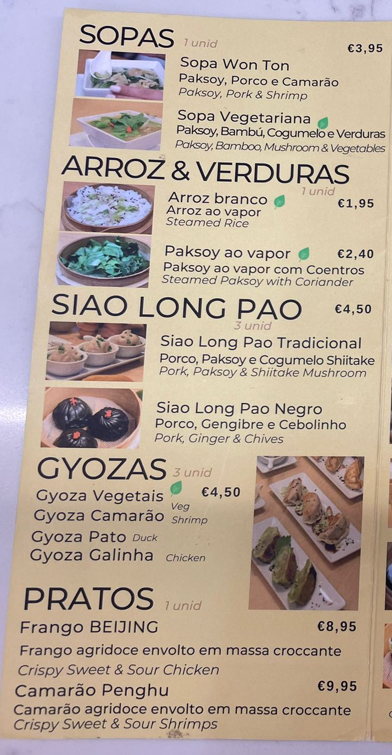

Enviando imagen al LLM ../imgs/menus/Dim Sum/DimSum Amoreiras 1.PNG
Procesando la respuesta del LLM para ../imgs/menus/Dim Sum/DimSum Amoreiras 1.PNG
	Añadiendo nuevo plato: Sopas/Sopa Won Ton
	Añadiendo nuevo plato: Sopas/Sopa Vegetariana
	Añadiendo nuevo plato: Arroz & Verduras/Arroz branco
	Añadiendo nuevo plato: Arroz & Verduras/Paksoy ao vapor
	Añadiendo nuevo plato: Siao Long Pao/Siao Long Pao Tradicional
	Añadiendo nuevo plato: Siao Long Pao/Siao Long Pao Negro
	Añadiendo nuevo plato: Gyozas/Gyoza Vegetais
	Añadiendo nuevo plato: Gyozas/Gyoza Camarão
	Añadiendo nuevo plato: Gyozas/Gyoza Pato
	Añadiendo nuevo plato: Gyozas/Gyoza Galinha
	Añadiendo nuevo plato: Pratos/Frango BEIJING
	Añadiendo nuevo plato: Pratos/Camarão Penghu


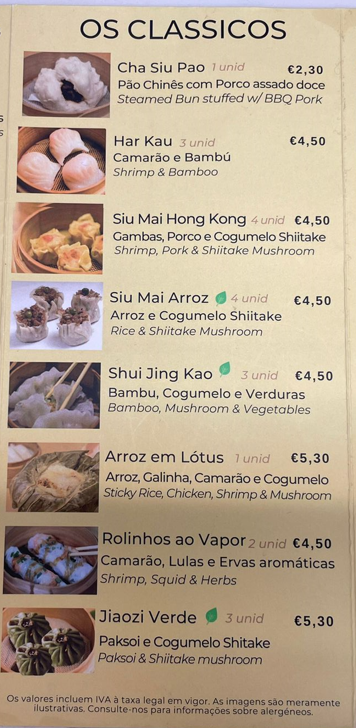

Enviando imagen al LLM ../imgs/menus/Dim Sum/DimSum Amoreiras 2.PNG
Procesando la respuesta del LLM para ../imgs/menus/Dim Sum/DimSum Amoreiras 2.PNG
	Añadiendo nuevo plato: Os Clássicos/Cha Siu Pao
	Añadiendo nuevo plato: Os Clássicos/Har Kau
	Añadiendo nuevo plato: Os Clássicos/Siu Mai Hong Kong
	Añadiendo nuevo plato: Os Clássicos/Siu Mai Arroz
	Añadiendo nuevo plato: Os Clássicos/Shui Jing Kao
	Añadiendo nuevo plato: Os Clássicos/Arroz em Lótus
	Añadiendo nuevo plato: Os Clássicos/Rolinhos ao Vapor
	Añadiendo nuevo plato: Os Clásicos/Jiaozi Verde


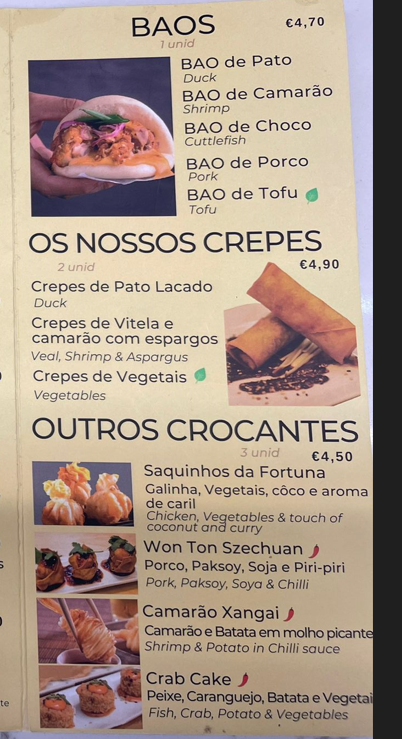

Enviando imagen al LLM ../imgs/menus/Dim Sum/DimSum Amoreiras 3.PNG
Procesando la respuesta del LLM para ../imgs/menus/Dim Sum/DimSum Amoreiras 3.PNG
	Añadiendo nuevo plato: BAOS/BAO de Pato
	Añadiendo nuevo plato: BAOS/BAO de Camarão
	Añadiendo nuevo plato: BAOS/BAO de Choco
	Añadiendo nuevo plato: BAOS/BAO de Porco
	Añadiendo nuevo plato: BAOS/BAO de Tofu
	Añadiendo nuevo plato: OS NOSSOS CREPES/Crepes de Pato Lacado
	Añadiendo nuevo plato: OS NOSSOS CREPES/Crepes de Vitela e camarão com espargos
	Añadiendo nuevo plato: OS NOSSOS CREPES/Crepes de Vegetais
	Añadiendo nuevo plato: OUTROS CROCANTES/Saquinhos da Fortuna
	Añadiendo nuevo plato: OUTROS CROCANTES/Won Ton Szechuan
	Añadiendo nuevo plato: OUTROS CROCANTES/Camarão Xangai
	Añadiendo nuevo plato: OUTROS CROCANTES/Crab Cake


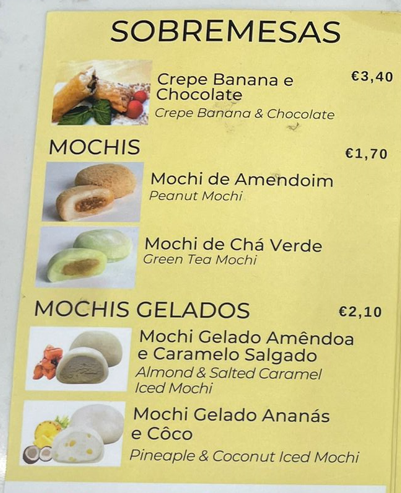

Enviando imagen al LLM ../imgs/menus/Dim Sum/DimSum Amoreiras 4.PNG
Procesando la respuesta del LLM para ../imgs/menus/Dim Sum/DimSum Amoreiras 4.PNG
	Añadiendo nuevo plato: SOBREMESAS/Crepe Banana e Chocolate
	Añadiendo nuevo plato: SOBREMESAS/Mochi de Amendoim
	Añadiendo nuevo plato: SOBREMESAS/Mochi de Chá Verde
	Añadiendo nuevo plato: SOBREMESAS/Mochi Gelado Amêndoa e Caramelo Salgado
	Añadiendo nuevo plato: SOBREMESAS/Mochi Gelado Ananás e Côco


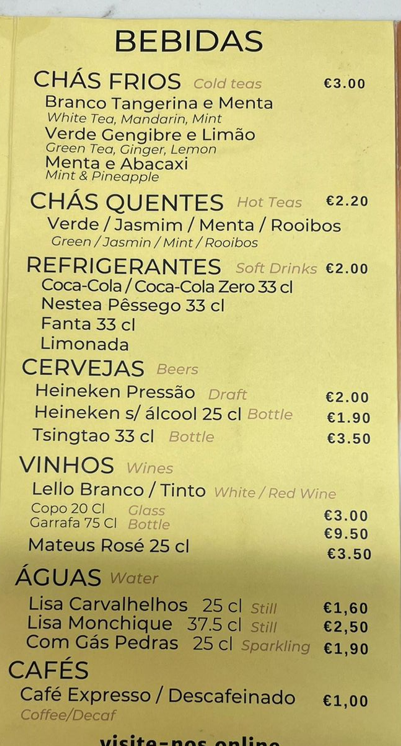

Enviando imagen al LLM ../imgs/menus/Dim Sum/DimSum Amoreiras 5.PNG
Procesando la respuesta del LLM para ../imgs/menus/Dim Sum/DimSum Amoreiras 5.PNG
	Añadiendo nuevo plato: Bebidas/Branco Tangerina e Menta
	Añadiendo nuevo plato: Bebidas/Verde Gengibre e Limão
	Añadiendo nuevo plato: Bebidas/Menta e Abacaxi
	Añadiendo nuevo plato: Bebidas/Verde / Jasmim / Menta / Rooibos
	Añadiendo nuevo plato: Bebidas/Coca-Cola / Coca-Cola Zero
	Añadiendo nuevo plato: Bebidas/Nestea Pêssego
	Añadiendo nuevo plato: Bebidas/Fanta
	Añadiendo nuevo plato: Bebidas/Limonada
	Añadiendo nuevo plato: Bebidas/Heineken Pressão
	Añadiendo nuevo plato: Bebidas/Heineken s/ álcool
	Añadiendo nuevo plato: Bebidas/Tsingtao
	Añadiendo nuevo plato: Bebidas/Lello Branco / Tinto - Copo
	Añadiendo nuevo plato: Bebidas/Lello Branco / Tinto - Garrafa
	Añadiendo nuevo plato: Bebidas/Mateus Rosé
	Añadiendo nuevo plato: Bebidas/Lisa Carvalhelhos
	Añadiendo nuevo plato: Bebidas/Lisa Monchique
	Añadiendo nuevo plato: Bebidas/Com

In [12]:
# Prompt the user for the excel file name
new_excel_file_name = input("Introduce el nombre del nuevo archivo Excel (sin extensión): ")
EXCEL_PATH = os.path.join(IMAGE_DIR, f"{new_excel_file_name}.xlsx")

# Crear el dataframe de PANDAS
df = pd.DataFrame(columns=['CategoryTitleEs', 'CategoryTitlePt', 'CategoryTitleEn', 'SubcategoryTitleEs', 'SubcategoryTitlePt', 'SubcategoryTitleEn',
                           'ItemNameEs', 'ItemNamePt', 'ItemNameEn', 'ItemPrice', 'Calories', 'PortionSize', 'Availability',
                           'ItemDescriptionEs', 'ItemDescriptionPt', 'ItemDescriptionEn'])


for image in image_files:
  # Retrieve and encode the image
  image_path = os.path.join(IMAGE_DIR, image)
  image_data = encode_image(image_path)

  # Adding a flag for the headers
  headers_added = False

  display(Image(filename=image_path, width=100))
  print(f"Enviando imagen al LLM {image_path}")
  response = client.chat.completions.create(
    model=MODEL,
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": [
            {'type': 'text',
             'text': "Convierte esta imagen de menú en un formato estructurado de hoja de Excel."},
            {'type': 'image_url',
             'image_url': {'url': f'data:image/png;base64,{image_data}'}}
        ]}
    ],
    temperature=0
  )

  print(f"Procesando la respuesta del LLM para {image_path}")
  for row in response.choices[0].message.content.split('\n'):
      if row.startswith('|') and not row.startswith('|-'): # Ensure that the data is a row and not a header format
        columns = [col.strip() for col in row.split('|')[1:-1]]
        if len(columns) == len(df.columns):
          if 'CategoryTitleEs' in columns:
            headers_added = True
            continue
          if headers_added and 'CategoryTitleEs' in columns:
            continue # skip the row
          new_row = pd.Series(columns, index=df.columns)
          print(f"\033[92m\tAñadiendo nuevo plato: {new_row['CategoryTitlePt']}/{new_row['ItemNamePt']}\033[0m")
          df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
        else:
          print(f"\033[91mSaltándose fila. Se esperaban {len(df.columns)} columnas, pero se encontraron {len(columns)}.\n { row}\033[0m")

df.to_excel(EXCEL_PATH, index=False)
print(f"Fichero de Excel grabado en: {EXCEL_PATH}")